In [1]:
%matplotlib inline

In [16]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from datasets import load_dataset
import unicodedata
import contractions
import textstat
import string
import re
import nltk
from collections import Counter
from textstat import flesch_reading_ease, syllable_count
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from syllapy import count as syllable_count
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.sparse import hstack
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.sparse import hstack, csr_matrix

import torch
import evaluate
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [3]:
# Get the dataset from Hello-SimpleAI/HC3
dataset = load_dataset("Hello-SimpleAI/HC3", "all")
df = pd.DataFrame(dataset["train"])

# Take a look at the dataset
df.head()

,id,question,human_answers,chatgpt_answers,source
0,0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,reddit_eli5
1,1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,reddit_eli5
2,2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,reddit_eli5
3,3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,reddit_eli5
4,4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,reddit_eli5


In [4]:
# Explode the human and ChatGPT answers so that each answer gets its own row
df = df.explode("human_answers").explode("chatgpt_answers")

# Create a new DataFrame for human and ChatGPT answers separately
df_human = pd.DataFrame({"text": df["human_answers"], "classification": 1})
df_chatgpt = pd.DataFrame({"text": df["chatgpt_answers"], "classification": 0})

# Concatenate both DataFrames
df_combined = pd.concat([df_human, df_chatgpt], ignore_index=True)

# Drop NaN values that might result from the explosion
df_combined = df_combined.dropna().reset_index(drop=True)

In [5]:
print(df_combined)

                                                     text  classification
0       Basically there are many categories of " Best ...               1
1       If you 're hearing about it , it 's because it...               1
2       One reason is lots of catagories . However , h...               1
3       salt is good for not dying in car crashes and ...               1
4       In Minnesota and North Dakota , they tend to u...               1
...                                                   ...             ...
121806  It's not uncommon for blood pressure to fluctu...               0
121807  There are several possible causes of a painles...               0
121808  It is not appropriate for me to recommend a sp...               0
121809  It is not uncommon for people with rheumatoid ...               0
121810  It is not uncommon to experience back pain, es...               0

[121811 rows x 2 columns]


In [6]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to count words
def word_count(text):
    return len(word_tokenize(text))

# Load the cleaned dataset (assuming df_combined is already prepared)
df = df_combined.copy()

# Step 1: Original Word Count
df["original_word_count"] = df["text"].apply(word_count)

# Step 2: Text Cleaning (Removing special characters, extra spaces, URLs, numbers)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["cleaned_text"] = df["text"].apply(clean_text)
df["cleaned_word_count"] = df["cleaned_text"].apply(word_count)

# Step 3: Tokenization
df["tokens"] = df["cleaned_text"].apply(word_tokenize)
df["tokenized_word_count"] = df["tokens"].apply(len)

# Step 4: Remove Stopwords
stop_words = set(stopwords.words("english"))
df["tokens_no_stopwords"] = df["tokens"].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df["no_stopwords_word_count"] = df["tokens_no_stopwords"].apply(len)

# Step 5: Lemmatization
lemmatizer = WordNetLemmatizer()
df["lemmatized_tokens"] = df["tokens_no_stopwords"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df["lemmatized_word_count"] = df["lemmatized_tokens"].apply(len)

# Step 6: Join lemmatized tokens back to text
df["final_text"] = df["lemmatized_tokens"].apply(lambda tokens: " ".join(tokens))
df["final_word_count"] = df["final_text"].apply(word_count)

[nltk_data] Downloading package punkt to /Users/dj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
print(df.head)

<bound method NDFrame.head of                                                      text  classification  \
0       Basically there are many categories of " Best ...               1   
1       If you 're hearing about it , it 's because it...               1   
2       One reason is lots of catagories . However , h...               1   
3       salt is good for not dying in car crashes and ...               1   
4       In Minnesota and North Dakota , they tend to u...               1   
...                                                   ...             ...   
121806  It's not uncommon for blood pressure to fluctu...               0   
121807  There are several possible causes of a painles...               0   
121808  It is not appropriate for me to recommend a sp...               0   
121809  It is not uncommon for people with rheumatoid ...               0   
121810  It is not uncommon to experience back pain, es...               0   

        original_word_count  \
0             

In [8]:
# Keep only the required columns
df_final = df[["final_text", "classification"]]

df_final.head

<bound method NDFrame.head of                                                final_text  classification
0       basically many category best seller replace be...               1
1       hearing good well publicized book almost every...               1
2       one reason lot catagories however ny time calc...               1
3       salt good dying car crash car crash worse car ...               1
4       minnesota north dakota tend use sand salt stat...               1
...                                                   ...             ...
121806  uncommon blood pressure fluctuate throughout d...               0
121807  several possible cause painless lump right arm...               0
121808  appropriate recommend specific medication trea...               0
121809  uncommon people rheumatoid arthritis ra fibrom...               0
121810  uncommon experience back pain especially stand...               0

[121811 rows x 2 columns]>

In [5]:
import os

if os.path.exists("df_featured.csv"):
    df = pd.read_csv("df_featured.csv")
    print("Loaded df_featured.csv from disk.")
else:
    # Load the final cleaned dataset
    df = df_final.copy()
    
    # Feature 1: Word Count
    df["word_count"] = df["final_text"].apply(lambda text: len(word_tokenize(text)))
    
    # Feature 2: Sentence Count
    df["sentence_count"] = df["final_text"].apply(lambda text: len(sent_tokenize(text)))
    
    # Feature 3: Average Sentence Length
    df["avg_sentence_length"] = df["word_count"] / df["sentence_count"].replace(0, 1)
    
    # Feature 4: Punctuation Count
    df["punctuation_count"] = df["final_text"].apply(lambda text: sum(1 for char in text if char in string.punctuation))
    
    # Feature 5: Readability Score (Flesch-Kincaid)
    df["readability_score"] = df["final_text"].apply(lambda text: textstat.flesch_reading_ease(text))
    
    # Feature 6: Unique Word Ratio
    df["unique_word_ratio"] = df["final_text"].apply(lambda text: len(set(word_tokenize(text))) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)
    
    # Feature 7: Average Word Length
    df["avg_word_length"] = df["final_text"].apply(lambda text: sum(len(word) for word in word_tokenize(text)) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)
    
    # Feature 8: Average Syllables Per Word
    df["avg_syllables_per_word"] = df["final_text"].apply(lambda text: sum(syllable_count(word) for word in word_tokenize(text)) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)
    
    # Feature 9 & 10: Sentiment Analysis (Polarity & Subjectivity)
    df["sentiment_polarity"] = df["final_text"].apply(lambda text: TextBlob(text).sentiment.polarity)
    df["sentiment_subjectivity"] = df["final_text"].apply(lambda text: TextBlob(text).sentiment.subjectivity)
    
    # Feature 11: Bias Detection (Using Specific Keywords)
    bias_keywords = ["opinion", "biased", "viewpoint", "perspective", "subjective"]
    df["bias_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in bias_keywords))
    
    # Feature 12: Affect Words (Emotion-Related Words)
    affect_keywords = ["happy", "sad", "anger", "joy", "fear", "love", "hate", "excited"]
    df["affect_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in affect_keywords))
    
    # Feature 13: Moral Words (Ethical & Value-Based Words)
    moral_keywords = ["justice", "fairness", "honest", "duty", "compassion", "loyalty"]
    df["moral_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in moral_keywords))
    
    # Feature 14: Removing AI Directive Phrases
    ai_directive_phrases = ["AI assistant", "I’m an AI model", "AI", "I am an AI", "As a language model"]
    df["cleaned_text_no_ai"] = df["final_text"].apply(lambda text: re.sub(r'\b(?:' + '|'.join(re.escape(phrase) for phrase in ai_directive_phrases) + r')\b', '', text, flags=re.IGNORECASE))

    # Feature 15: Extract n-grams (bigrams & trigrams)
    def get_ngram_frequencies(text, n=2):
        words = text.split()
        ngrams = zip(*[words[i:] for i in range(n)])
        return Counter(ngrams).most_common(10)
    
    df["bigrams"] = df["final_text"].apply(lambda x: get_ngram_frequencies(x, 2))
    df["trigrams"] = df["final_text"].apply(lambda x: get_ngram_frequencies(x, 3))

    df.to_csv("df_featured.csv", index=False)
    print("Feature engineering complete and saved to df_featured.csv")

Loaded df_featured.csv from disk.


In [6]:
df = pd.read_csv("df_featured.csv")
df = df.dropna(subset=["final_text"])
df.head()

,final_text,classification,word_count,sentence_count,avg_sentence_length,punctuation_count,readability_score,unique_word_ratio,avg_word_length,avg_syllables_per_word,sentiment_polarity,sentiment_subjectivity,bias_score,affect_score,moral_score,cleaned_text_no_ai,bigrams,trigrams
0,basically many category best seller replace be...,1,61,1,61.0,0,9.56,0.557377,5.098361,1.557377,0.746429,0.364286,0,0,0,basically many category best seller replace be...,"[(('best', 'seller'), 6), (('something', 'like...","[(('basically', 'many', 'category'), 1), (('ma..."
1,hearing good well publicized book almost every...,1,29,1,29.0,0,33.58,0.758621,5.241379,1.689655,0.268750,0.466667,0,0,0,hearing good well publicized book almost every...,"[(('good', 'well'), 2), (('well', 'publicized'...","[(('good', 'well', 'publicized'), 2), (('well'..."
2,one reason lot catagories however ny time calc...,1,29,1,29.0,1,42.04,0.896552,5.517241,1.724138,0.347143,0.547143,0,0,0,one reason lot catagories however ny time calc...,"[(('one', 'reason'), 1), (('reason', 'lot'), 1...","[(('one', 'reason', 'lot'), 1), (('reason', 'l..."
3,salt good dying car crash car crash worse car ...,1,22,1,22.0,0,66.07,0.727273,5.000000,1.409091,0.330000,0.700000,0,0,0,salt good dying car crash car crash worse car ...,"[(('car', 'crash'), 2), (('salt', 'good'), 1),...","[(('salt', 'good', 'dying'), 1), (('good', 'dy..."
4,minnesota north dakota tend use sand salt stat...,1,50,1,50.0,0,20.73,0.840000,5.300000,1.620000,-0.002755,0.625758,0,0,0,minnesota north dakota tend use sand salt stat...,"[(('minnesota', 'north'), 1), (('north', 'dako...","[(('minnesota', 'north', 'dakota'), 1), (('nor..."


In [8]:
print(f"Total words in dataset: {df['word_count'].sum()}")

Total words in dataset: 8954279


In [9]:
df["word_count_no_ai"] = df["cleaned_text_no_ai"].apply(lambda text: len(word_tokenize(text)))
print(f"Total words with no ai in dataset: {df['word_count_no_ai'].sum()}")

Total words with no ai in dataset: 8952884


In [11]:
print("Non-Zero Value Counts:")
print("Bias Score:", (df["bias_score"] != 0).sum())
print("Affect Score:", (df["affect_score"] != 0).sum())
print("Moral Score:", (df["moral_score"] != 0).sum())
print("Punctuation Count:", (df["punctuation_count"] != 0).sum())

Non-Zero Value Counts:
Bias Score: 2762
Affect Score: 4508
Moral Score: 1450
Punctuation Count: 7232


# Initial Experiment

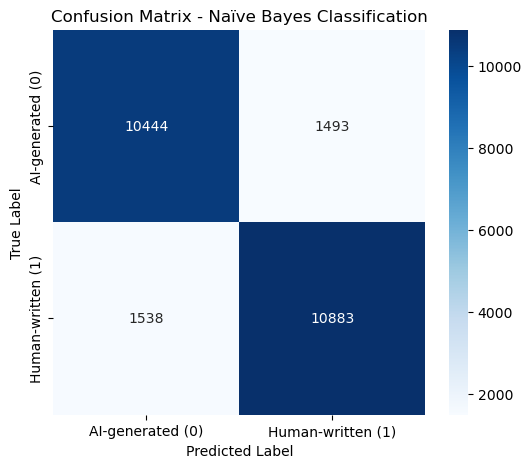

                   precision    recall  f1-score       support
AI-generated (0)    0.871641  0.874927  0.873281  11937.000000
Human-written (1)   0.879363  0.876177  0.877767  12421.000000
accuracy            0.875564  0.875564  0.875564      0.875564
macro avg           0.875502  0.875552  0.875524  24358.000000
weighted avg        0.875579  0.875564  0.875569  24358.000000


In [8]:
# Convert text data into TF-IDF feature vectors
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["final_text"])  # Feature matrix
y = df["classification"]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["AI-generated (0)", "Human-written (1)"]

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naïve Bayes Classification")
plt.show()

# Convert classification report to a DataFrame for better display
report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

## With unigram bigram trigram + other models


=== Naïve Bayes ===
Accuracy: 0.8970

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.90      0.89      0.89     11937
Human-written (1)       0.89      0.91      0.90     12421

         accuracy                           0.90     24358
        macro avg       0.90      0.90      0.90     24358
     weighted avg       0.90      0.90      0.90     24358



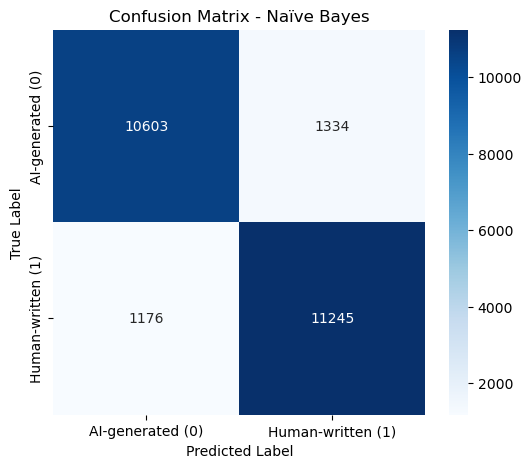

                   precision    recall  f1-score       support
AI-generated (0)    0.900161  0.888247  0.894164  11937.000000
Human-written (1)   0.893950  0.905322  0.899600  12421.000000
accuracy            0.896954  0.896954  0.896954      0.896954
macro avg           0.897056  0.896784  0.896882  24358.000000
weighted avg        0.896994  0.896954  0.896936  24358.000000

=== Logistic Regression ===
Accuracy: 0.9479

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.94      0.95      0.95     11937
Human-written (1)       0.95      0.95      0.95     12421

         accuracy                           0.95     24358
        macro avg       0.95      0.95      0.95     24358
     weighted avg       0.95      0.95      0.95     24358



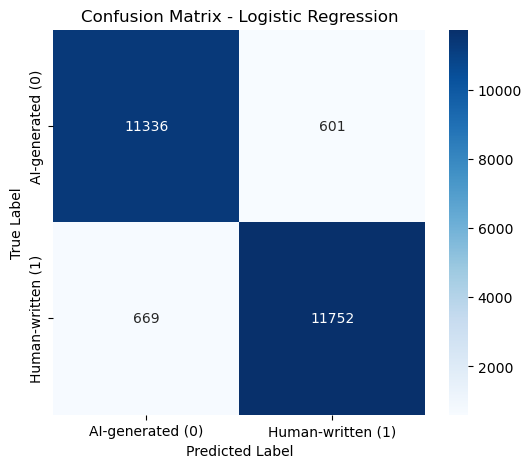

                   precision    recall  f1-score       support
AI-generated (0)    0.944273  0.949652  0.946955  11937.000000
Human-written (1)   0.951348  0.946140  0.948737  12421.000000
accuracy            0.947861  0.947861  0.947861      0.947861
macro avg           0.947811  0.947896  0.947846  24358.000000
weighted avg        0.947881  0.947861  0.947864  24358.000000

=== SVM ===
Accuracy: 0.9610

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.96      0.96      0.96     11937
Human-written (1)       0.97      0.96      0.96     12421

         accuracy                           0.96     24358
        macro avg       0.96      0.96      0.96     24358
     weighted avg       0.96      0.96      0.96     24358



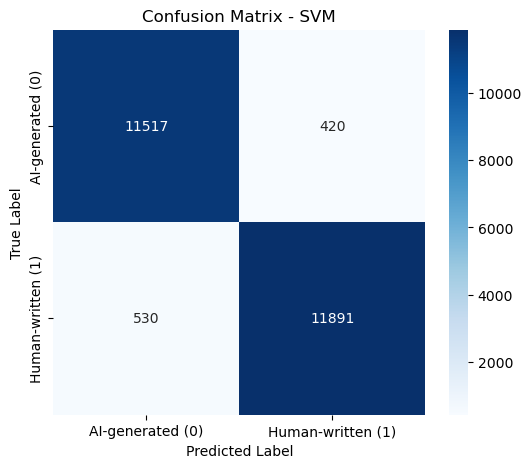

                   precision    recall  f1-score       support
AI-generated (0)    0.956006  0.964815  0.960390  11937.000000
Human-written (1)   0.965884  0.957330  0.961588  12421.000000
accuracy            0.960998  0.960998  0.960998      0.960998
macro avg           0.960945  0.961073  0.960989  24358.000000
weighted avg        0.961043  0.960998  0.961001  24358.000000

=== Random Forest ===
Accuracy: 0.9784

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.97      0.98      0.98     11937
Human-written (1)       0.98      0.97      0.98     12421

         accuracy                           0.98     24358
        macro avg       0.98      0.98      0.98     24358
     weighted avg       0.98      0.98      0.98     24358



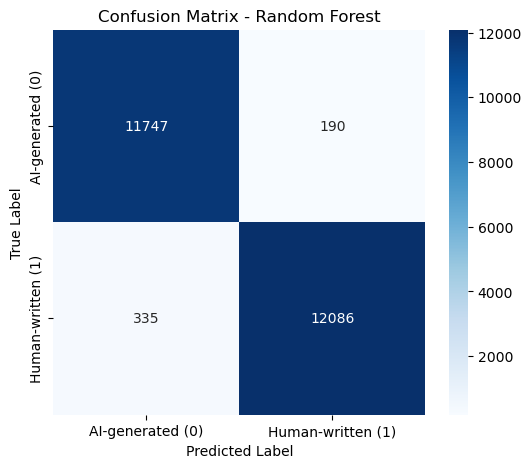

                   precision    recall  f1-score       support
AI-generated (0)    0.972273  0.984083  0.978142  11937.000000
Human-written (1)   0.984523  0.973030  0.978742  12421.000000
accuracy            0.978447  0.978447  0.978447      0.978447
macro avg           0.978398  0.978556  0.978442  24358.000000
weighted avg        0.978519  0.978447  0.978448  24358.000000

=== XGBoost ===
Accuracy: 0.9613

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.96      0.96      0.96     11937
Human-written (1)       0.96      0.97      0.96     12421

         accuracy                           0.96     24358
        macro avg       0.96      0.96      0.96     24358
     weighted avg       0.96      0.96      0.96     24358



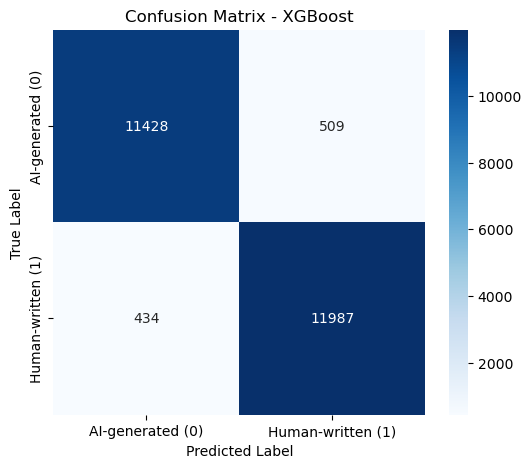

                   precision    recall  f1-score       support
AI-generated (0)    0.963413  0.957359  0.960376  11937.000000
Human-written (1)   0.959267  0.965059  0.962154  12421.000000
accuracy            0.961286  0.961286  0.961286      0.961286
macro avg           0.961340  0.961209  0.961265  24358.000000
weighted avg        0.961299  0.961286  0.961283  24358.000000


In [6]:
# Convert text data into TF-IDF feature vectors
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = vectorizer.fit_transform(df["final_text"])
y = df["classification"]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classifiers to evaluate
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": LinearSVC(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report
    classification_rep = classification_report(y_test, y_pred, target_names=["AI-generated (0)", "Human-written (1)"])
    print("\nClassification Report:")
    print(classification_rep)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = ["AI-generated (0)", "Human-written (1)"]
    
    # Visualize Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    # Display classification report as DataFrame
    report_df = pd.DataFrame(classification_report(y_test, y_pred, target_names=labels, output_dict=True)).transpose()
    print(report_df)

##  More feature introduced (Numerical + TF-IDF)


=== Naïve Bayes ===
Accuracy: 0.9147

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.93      0.89      0.91     11937
Human-written (1)       0.90      0.93      0.92     12421

         accuracy                           0.91     24358
        macro avg       0.92      0.91      0.91     24358
     weighted avg       0.92      0.91      0.91     24358



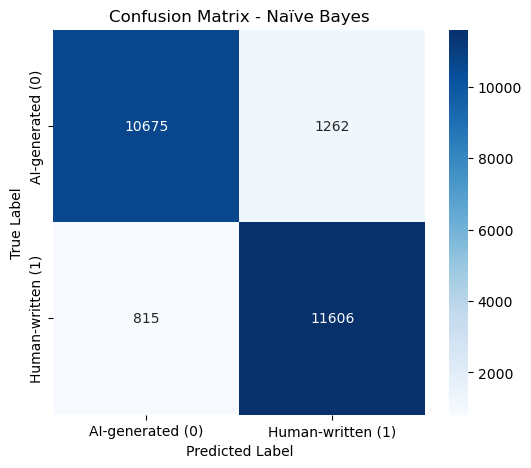

                   precision    recall  f1-score      support
AI-generated (0)    0.929069  0.894278  0.911342  11937.00000
Human-written (1)   0.901927  0.934385  0.917869  12421.00000
accuracy            0.914730  0.914730  0.914730      0.91473
macro avg           0.915498  0.914332  0.914606  24358.00000
weighted avg        0.915228  0.914730  0.914670  24358.00000
Model Naïve Bayes saved

scaler saved.



In [31]:
# Prepare features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_text = vectorizer.fit_transform(df["final_text"])

numeric_columns = [
    "word_count", "sentence_count", "avg_sentence_length", "punctuation_count",
    "readability_score", "unique_word_ratio", "avg_word_length",
    "avg_syllables_per_word", "sentiment_polarity", "sentiment_subjectivity",
    "bias_score", "affect_score", "moral_score"
]
scaler = MinMaxScaler()
X_numeric = scaler.fit_transform(df[numeric_columns])

X_combined = hstack([X_text, csr_matrix(X_numeric)])
y = df["classification"]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Models
model = MultinomialNB()
label = ["AI-generated (0)", "Human-written (1)"]
os.makedirs("saved_models", exist_ok=True)

# Training, evaluation, and saving
print(f"\n=== Naïve Bayes ===")
    
# Train
model.fit(X_train, y_train)
    
# Predict
y_pred = model.predict(X_test)
    
# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))
    
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Naïve Bayes")
plt.show()
    
report_df = pd.DataFrame(classification_report(y_test, y_pred, target_names=labels, output_dict=True)).transpose()
print(report_df)

# Save the model
joblib.dump(model, f"saved_models/model_NB.joblib")
print(f"Model Naïve Bayes saved\n")
joblib.dump(scaler, "saved_models/numeric_scaler_nb.joblib")
print("scaler saved.\n")


=== LOGISTIC REGRESSION ===
Accuracy: 0.9687

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.96      0.98      0.97     11937
Human-written (1)       0.98      0.96      0.97     12421

         accuracy                           0.97     24358
        macro avg       0.97      0.97      0.97     24358
     weighted avg       0.97      0.97      0.97     24358



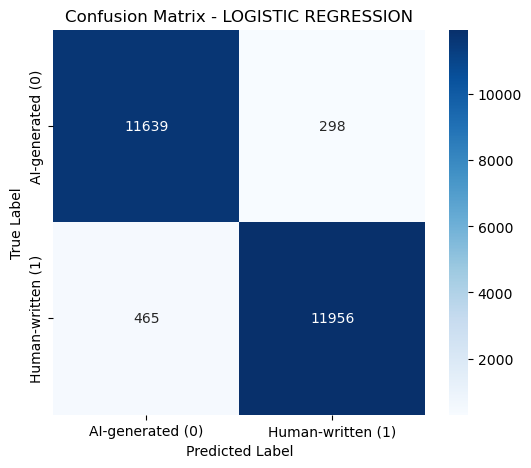

                   precision    recall  f1-score       support
AI-generated (0)    0.961583  0.975036  0.968263  11937.000000
Human-written (1)   0.975681  0.962563  0.969078  12421.000000
accuracy            0.968676  0.968676  0.968676      0.968676
macro avg           0.968632  0.968800  0.968670  24358.000000
weighted avg        0.968772  0.968676  0.968678  24358.000000
Model Logistic Regression saved


=== SVM ===
Accuracy: 0.9780

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.97      0.98      0.98     11937
Human-written (1)       0.98      0.97      0.98     12421

         accuracy                           0.98     24358
        macro avg       0.98      0.98      0.98     24358
     weighted avg       0.98      0.98      0.98     24358



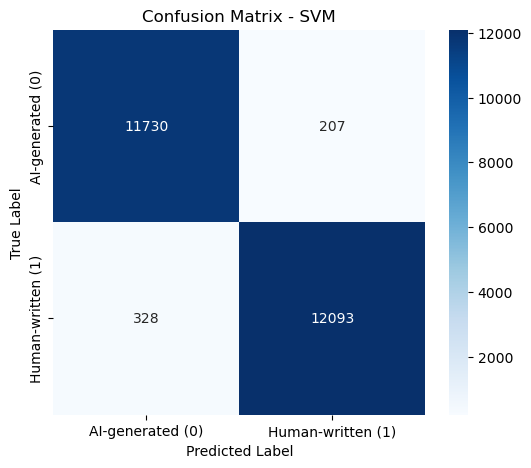

                   precision    recall  f1-score       support
AI-generated (0)    0.972798  0.982659  0.977704  11937.000000
Human-written (1)   0.983171  0.973593  0.978358  12421.000000
accuracy            0.978036  0.978036  0.978036      0.978036
macro avg           0.977984  0.978126  0.978031  24358.000000
weighted avg        0.978087  0.978036  0.978038  24358.000000
Model SVM saved


=== RANDOM FOREST ===
Accuracy: 0.9791

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.97      0.99      0.98     11937
Human-written (1)       0.99      0.97      0.98     12421

         accuracy                           0.98     24358
        macro avg       0.98      0.98      0.98     24358
     weighted avg       0.98      0.98      0.98     24358



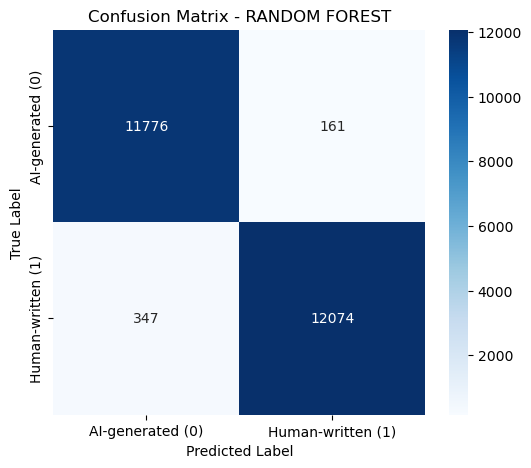

                   precision    recall  f1-score       support
AI-generated (0)    0.971377  0.986513  0.978886  11937.000000
Human-written (1)   0.986841  0.972063  0.979396  12421.000000
accuracy            0.979144  0.979144  0.979144      0.979144
macro avg           0.979109  0.979288  0.979141  24358.000000
weighted avg        0.979263  0.979144  0.979146  24358.000000
Model Random Forest saved


=== XGBOOST ===
Accuracy: 0.9748

Classification Report:
                   precision    recall  f1-score   support

 AI-generated (0)       0.97      0.98      0.97     11937
Human-written (1)       0.98      0.97      0.98     12421

         accuracy                           0.97     24358
        macro avg       0.97      0.97      0.97     24358
     weighted avg       0.97      0.97      0.97     24358



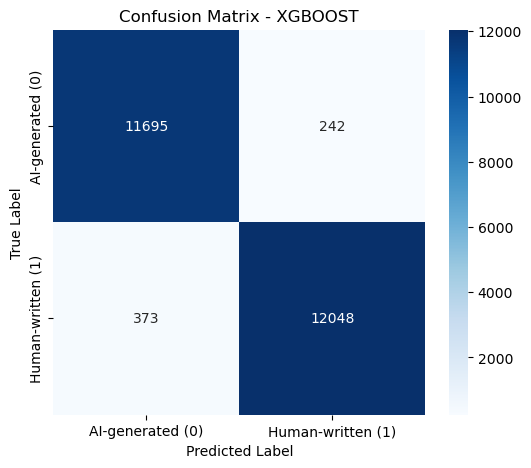

                   precision    recall  f1-score       support
AI-generated (0)    0.969092  0.979727  0.974380  11937.000000
Human-written (1)   0.980309  0.969970  0.975112  12421.000000
accuracy            0.974752  0.974752  0.974752      0.974752
macro avg           0.974701  0.974849  0.974746  24358.000000
weighted avg        0.974812  0.974752  0.974754  24358.000000
Model XGBoost saved

Vectorizer and scaler saved.



In [14]:
# Prepare features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_text = vectorizer.fit_transform(df["final_text"])

numeric_columns = [
    "word_count", "sentence_count", "avg_sentence_length", "punctuation_count",
    "readability_score", "unique_word_ratio", "avg_word_length",
    "avg_syllables_per_word", "sentiment_polarity", "sentiment_subjectivity",
    "bias_score", "affect_score", "moral_score"
]
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[numeric_columns])

X_combined = hstack([X_text, csr_matrix(X_numeric)])
y = df["classification"]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": LinearSVC(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

labels = ["AI-generated (0)", "Human-written (1)"]
os.makedirs("saved_models", exist_ok=True)

# Training, evaluation, and saving
for name, model in models.items():
    print(f"\n=== {name.upper()} ===")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name.upper()}")
    plt.show()
    
    report_df = pd.DataFrame(classification_report(y_test, y_pred, target_names=labels, output_dict=True)).transpose()
    print(report_df)

    # Save the model
    joblib.dump(model, f"saved_models/model_{name}.joblib")
    print(f"Model {name} saved\n")

# Save vectorizer and scaler
joblib.dump(vectorizer, "saved_models/vectorizer_tfidf.joblib")
joblib.dump(scaler, "saved_models/numeric_scaler.joblib")
print("Vectorizer and scaler saved.\n")

In [9]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## DistilRoBERTa

In [14]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Load accuracy metric
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Convert logits to class predictions
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {"accuracy": accuracy["accuracy"], "f1_score": f1["f1"]}

In [16]:
# Load tokenizer for DistilRoBERTa
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

# Define PyTorch Dataset class for tokenized text
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df["final_text"], df["classification"], test_size=0.2, random_state=42)


# Convert data into dataset format
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# Load pre-trained DistilRoBERTa model for binary classification
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)
model.to(device)  # Move model to GPU if available

# Define training arguments
training_args = TrainingArguments(
    output_dir="./distilroberta_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Check if model is already saved
if os.path.exists("distilroberta_finetuned"):
    print("Model already exists. Loading skipped training.")
    model = AutoModelForSequenceClassification.from_pretrained("distilroberta_finetuned")
    tokenizer = AutoTokenizer.from_pretrained("distilroberta_finetuned")
else:
    print("No saved model found. Training now...")

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    trainer.train()
    
    # Save the fine-tuned model and tokenizer
    trainer.save_model("distilroberta_finetuned")
    tokenizer.save_pretrained("distilroberta_finetuned")
    print("DistilRoBERTa model and tokenizer saved.")

No saved model found. Training now...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.064200,0.044211,0.990722,0.990722
2,0.031700,0.065715,0.987602,0.987603
3,0.000100,0.042069,0.992898,0.992898


DistilRoBERTa model and tokenizer saved.


## Stacking Random Forest + XGBoost → Logistic Regression

In [10]:
# Prepare features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_text = vectorizer.fit_transform(df["final_text"])

numeric_columns = [
    "word_count", "sentence_count", "avg_sentence_length", "punctuation_count",
    "readability_score", "unique_word_ratio", "avg_word_length",
    "avg_syllables_per_word", "sentiment_polarity", "sentiment_subjectivity",
    "bias_score", "affect_score", "moral_score"
]
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[numeric_columns])

X_combined = hstack([X_text, csr_matrix(X_numeric)])
y = df["classification"]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [11]:
# Load models
model1 = joblib.load("saved_models/model_Random Forest.joblib")
model2 = joblib.load("saved_models/model_XGBoost.joblib")

proba1 = model1.predict_proba(X_test)
proba2 = model2.predict_proba(X_test)

# Combine
X_meta = np.hstack([proba1, proba2])

# meta-model
meta_model = LogisticRegression()
meta_model.fit(X_meta, y_test)

# Predict
y_pred_stacked = meta_model.predict(X_meta)

# Evaluate
print("Manual Stacking (Random Forest + XGBoost → Logistic)")
print("Accuracy:", accuracy_score(y_test, y_pred_stacked))
print(classification_report(y_test, y_pred_stacked))

joblib.dump(meta_model, "saved_models/meta_model_stacked.joblib")
print("Meta-model saved to saved_models/meta_model_stacked.joblib")

Manual Stacking (Random Forest + XGBoost → Logistic)
Accuracy: 0.9834961819525413
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11937
           1       0.99      0.98      0.98     12421

    accuracy                           0.98     24358
   macro avg       0.98      0.98      0.98     24358
weighted avg       0.98      0.98      0.98     24358

Meta-model saved to saved_models/meta_model_stacked.joblib


## Stacking DistilRoBERTa + XGBoost

In [18]:
# Load model
vectorizer = joblib.load("saved_models/vectorizer_tfidf.joblib")
scaler = joblib.load("saved_models/numeric_scaler.joblib")
X_text = vectorizer.transform(df["final_text"])
X_numeric = scaler.transform(df[numeric_columns])
X_combined = hstack([X_text, csr_matrix(X_numeric)])

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_combined, df["classification"], df, test_size=0.2, random_state=42)

# XGBoost
xgb_model = joblib.load("saved_models/model_XGBoost.joblib")
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# RoBERTa
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilroberta_finetuned")
model = AutoModelForSequenceClassification.from_pretrained("distilroberta_finetuned")

# Dataset
class RobertaDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True)

    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}

    def __len__(self):
        return len(self.encodings["input_ids"])

test_dataset = RobertaDataset(df_test["final_text"].tolist())
trainer = Trainer(model=model)
roberta_outputs = trainer.predict(test_dataset)
roberta_probs = torch.nn.functional.softmax(torch.tensor(roberta_outputs.predictions), dim=1)[:, 1].numpy()

# Stacking input
stacked_input = np.vstack([xgb_probs, roberta_probs]).T

# Train meta-classifier
meta_model = LogisticRegression()
meta_model.fit(stacked_input, y_test)

# Predict and evaluate
y_pred = meta_model.predict(stacked_input)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=["AI-generated", "Human-written"]))

Accuracy: 0.9933
               precision    recall  f1-score   support

 AI-generated       0.99      1.00      0.99     11937
Human-written       1.00      0.99      0.99     12421

     accuracy                           0.99     24358
    macro avg       0.99      0.99      0.99     24358
 weighted avg       0.99      0.99      0.99     24358



# Test on new data to evaluate generaliztion

## Test on https://huggingface.co/datasets/agentlans/real-vs-gpt2-sentences-classification with Stacking Random Forest + XGBoost → Logistic Regression

In [2]:
ds = load_dataset("agentlans/real-vs-gpt2-sentences-classification")

In [3]:
df = pd.DataFrame(ds["train"])

# Take a look at the dataset
df.head()

,text,class
0,"Not only birds but the soil, soil and water ar...",gpt2
1,All farms will have more time to comply with w...,real
2,Start by sketching your world out in a bunch o...,gpt2
3,Counter-terrorism expert Professor Greg Barton...,real
4,Everyday we consume tonnes of endangered fish.,real


In [4]:
# Restructure dataset
df["classification"] = df["class"].map({"gpt2": 0, "real": 1})
df = df.drop(columns=["class"])

df.tail()

,text,classification
458669,A lot remains to be done but it seems that thi...,0
458670,Even though too much screen time could be detr...,1
458671,"Rubber, mastic, and filler tapes.",0
458672,"Along the way, they reformed Mexico's once fra...",1
458673,How does one determine if a person is a felon?,0


In [5]:
df = df.head(2000)

df.tail()

,text,classification
1995,This acts as an anchor for a greater number of...,0
1996,Some Irish Americans are heavily involved in t...,1
1997,Use it as an opportunity to start your career ...,0
1998,"For the most part, it enhances thinking.",1
1999,"In options trading, terms such as ""securities""...",0


In [6]:
# Function to count words
def word_count(text):
    return len(word_tokenize(text))

# Load the cleaned dataset
df = df.copy()

# Step 1: Original Word Count
df["original_word_count"] = df["text"].apply(word_count)

# Step 2: Text Cleaning (Removing special characters, extra spaces, URLs, numbers)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["cleaned_text"] = df["text"].apply(clean_text)
df["cleaned_word_count"] = df["cleaned_text"].apply(word_count)

# Step 3: Tokenization
df["tokens"] = df["cleaned_text"].apply(word_tokenize)
df["tokenized_word_count"] = df["tokens"].apply(len)

# Step 4: Remove Stopwords
stop_words = set(stopwords.words("english"))
df["tokens_no_stopwords"] = df["tokens"].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df["no_stopwords_word_count"] = df["tokens_no_stopwords"].apply(len)

# Step 5: Lemmatization
lemmatizer = WordNetLemmatizer()
df["lemmatized_tokens"] = df["tokens_no_stopwords"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df["lemmatized_word_count"] = df["lemmatized_tokens"].apply(len)

# Step 6: Join lemmatized tokens back to text
df["final_text"] = df["lemmatized_tokens"].apply(lambda tokens: " ".join(tokens))
df["final_word_count"] = df["final_text"].apply(word_count)

In [7]:
df_new = df.copy()

df_new.tail()

,text,classification,original_word_count,cleaned_text,cleaned_word_count,tokens,tokenized_word_count,tokens_no_stopwords,no_stopwords_word_count,lemmatized_tokens,lemmatized_word_count,final_text,final_word_count
1995,This acts as an anchor for a greater number of...,0,27,this acts as an anchor for a greater number of...,25,"[this, acts, as, an, anchor, for, a, greater, ...",25,"[acts, anchor, greater, number, people, wish, ...",12,"[act, anchor, greater, number, people, wish, c...",12,act anchor greater number people wish contribu...,12
1996,Some Irish Americans are heavily involved in t...,1,10,some irish americans are heavily involved in t...,9,"[some, irish, americans, are, heavily, involve...",9,"[irish, americans, heavily, involved, ethnicity]",5,"[irish, american, heavily, involved, ethnicity]",5,irish american heavily involved ethnicity,5
1997,Use it as an opportunity to start your career ...,0,19,use it as an opportunity to start your career ...,18,"[use, it, as, an, opportunity, to, start, your...",18,"[use, opportunity, start, career, get, next, p...",8,"[use, opportunity, start, career, get, next, p...",8,use opportunity start career get next phase ca...,8
1998,"For the most part, it enhances thinking.",1,9,for the most part it enhances thinking,7,"[for, the, most, part, it, enhances, thinking]",7,"[part, enhances, thinking]",3,"[part, enhances, thinking]",3,part enhances thinking,3
1999,"In options trading, terms such as ""securities""...",0,21,in options trading terms such as securities an...,15,"[in, options, trading, terms, such, as, securi...",15,"[options, trading, terms, securities, fees, tr...",8,"[option, trading, term, security, fee, treated...",8,option trading term security fee treated separ...,8


In [12]:
df_new = df_new[["final_text", "classification"]]

df_new.head()

,final_text,classification
0,bird soil soil water connected,0
1,farm time comply water quality requirement,1
2,start sketching world bunch little cube starti...,0
3,counter terrorism expert professor greg barton...,1
4,everyday consume tonne endangered fish,1


In [13]:
import os

if os.path.exists("df_featured_test.csv"):
    df = pd.read_csv("df_featured_test.csv")
    print("Loaded df_featured_test.csv from disk.")
else:
    # Load the final cleaned dataset
    df = df_new.copy()
    
    # Feature 1: Word Count
    df["word_count"] = df["final_text"].apply(lambda text: len(word_tokenize(text)))
    
    # Feature 2: Sentence Count
    df["sentence_count"] = df["final_text"].apply(lambda text: len(sent_tokenize(text)))
    
    # Feature 3: Average Sentence Length
    df["avg_sentence_length"] = df["word_count"] / df["sentence_count"].replace(0, 1)
    
    # Feature 4: Punctuation Count
    df["punctuation_count"] = df["final_text"].apply(lambda text: sum(1 for char in text if char in string.punctuation))
    
    # Feature 5: Readability Score (Flesch-Kincaid)
    df["readability_score"] = df["final_text"].apply(lambda text: textstat.flesch_reading_ease(text))
    
    # Feature 6: Unique Word Ratio
    df["unique_word_ratio"] = df["final_text"].apply(lambda text: len(set(word_tokenize(text))) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)
    
    # Feature 7: Average Word Length
    df["avg_word_length"] = df["final_text"].apply(lambda text: sum(len(word) for word in word_tokenize(text)) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)
    
    # Feature 8: Average Syllables Per Word
    df["avg_syllables_per_word"] = df["final_text"].apply(lambda text: sum(syllable_count(word) for word in word_tokenize(text)) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)
    
    # Feature 9 & 10: Sentiment Analysis (Polarity & Subjectivity)
    df["sentiment_polarity"] = df["final_text"].apply(lambda text: TextBlob(text).sentiment.polarity)
    df["sentiment_subjectivity"] = df["final_text"].apply(lambda text: TextBlob(text).sentiment.subjectivity)
    
    # Feature 11: Bias Detection (Using Specific Keywords)
    bias_keywords = ["opinion", "biased", "viewpoint", "perspective", "subjective"]
    df["bias_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in bias_keywords))
    
    # Feature 12: Affect Words (Emotion-Related Words)
    affect_keywords = ["happy", "sad", "anger", "joy", "fear", "love", "hate", "excited"]
    df["affect_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in affect_keywords))
    
    # Feature 13: Moral Words (Ethical & Value-Based Words)
    moral_keywords = ["justice", "fairness", "honest", "duty", "compassion", "loyalty"]
    df["moral_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in moral_keywords))
    
    # Feature 14: Removing AI Directive Phrases
    ai_directive_phrases = ["AI assistant", "I’m an AI model", "AI", "I am an AI", "As a language model"]
    df["cleaned_text_no_ai"] = df["final_text"].apply(lambda text: re.sub(r'\b(?:' + '|'.join(re.escape(phrase) for phrase in ai_directive_phrases) + r')\b', '', text, flags=re.IGNORECASE))

    # Feature 15: Extract n-grams (bigrams & trigrams)
    def get_ngram_frequencies(text, n=2):
        words = text.split()
        ngrams = zip(*[words[i:] for i in range(n)])
        return Counter(ngrams).most_common(10)
    
    df["bigrams"] = df["final_text"].apply(lambda x: get_ngram_frequencies(x, 2))
    df["trigrams"] = df["final_text"].apply(lambda x: get_ngram_frequencies(x, 3))

    df.to_csv("df_featured_test.csv", index=False)
    print("Feature engineering complete and saved to df_featured_test.csv")

Feature engineering complete and saved to df_featured_test.csv


In [14]:
df_new = df.copy()

df_new.head()

,final_text,classification,word_count,sentence_count,avg_sentence_length,punctuation_count,readability_score,unique_word_ratio,avg_word_length,avg_syllables_per_word,sentiment_polarity,sentiment_subjectivity,bias_score,affect_score,moral_score,cleaned_text_no_ai,bigrams,trigrams
0,bird soil soil water connected,0,5,1,5.0,0,66.40,0.800000,5.200000,1.600000,0.00000,0.0,0,0,0,bird soil soil water connected,"[((bird, soil), 1), ((soil, soil), 1), ((soil,...","[((bird, soil, soil), 1), ((soil, soil, water)..."
1,farm time comply water quality requirement,1,6,1,6.0,0,31.55,1.000000,6.166667,2.000000,0.00000,0.0,0,0,0,farm time comply water quality requirement,"[((farm, time), 1), ((time, comply), 1), ((com...","[((farm, time, comply), 1), ((time, comply, wa..."
2,start sketching world bunch little cube starti...,0,13,1,13.0,0,41.36,0.923077,6.461538,1.615385,-0.09375,0.3,0,0,0,start sketching world bunch little cube starti...,"[((start, sketching), 1), ((sketching, world),...","[((start, sketching, world), 1), ((sketching, ..."
3,counter terrorism expert professor greg barton...,1,13,1,13.0,0,-17.87,1.000000,7.384615,2.461538,0.00000,0.0,0,0,0,counter terrorism expert professor greg barton...,"[((counter, terrorism), 1), ((terrorism, exper...","[((counter, terrorism, expert), 1), ((terroris..."
4,everyday consume tonne endangered fish,1,5,1,5.0,0,32.56,1.000000,6.800000,2.200000,-0.20000,0.6,0,0,0,everyday consume tonne endangered fish,"[((everyday, consume), 1), ((consume, tonne), ...","[((everyday, consume, tonne), 1), ((consume, t..."


In [15]:
numeric_columns = [
    "word_count", "sentence_count", "avg_sentence_length", "punctuation_count",
    "readability_score", "unique_word_ratio", "avg_word_length",
    "avg_syllables_per_word", "sentiment_polarity", "sentiment_subjectivity",
    "bias_score", "affect_score", "moral_score"
]

# Load saved vectorizer, scaler, base models, and meta model
vectorizer = joblib.load("saved_models/vectorizer_tfidf.joblib")
scaler = joblib.load("saved_models/numeric_scaler.joblib")
model_rf = joblib.load("saved_models/model_Random Forest.joblib")
model_xgb = joblib.load("saved_models/model_XGBoost.joblib")
meta_model = joblib.load("saved_models/meta_model_stacked.joblib")


# Preprocess new dataset
X_text_new = vectorizer.transform(df_new["final_text"])
X_numeric_new = scaler.transform(df_new[numeric_columns])
X_new_combined = hstack([X_text_new, csr_matrix(X_numeric_new)])
y_new = df_new["classification"]  # Ground truth

# Generate base model predictions
proba_rf = model_rf.predict_proba(X_new_combined)
proba_xgb = model_xgb.predict_proba(X_new_combined)
X_meta_new = np.hstack([proba_rf, proba_xgb])

# Meta model prediction and evaluation
y_pred_new = meta_model.predict(X_meta_new)

print("Evaluation on new dataset (generalization test):")
print(f"Accuracy: {accuracy_score(y_new, y_pred_new):.4f}")
print(classification_report(y_new, y_pred_new))

Evaluation on new dataset (generalization test):
Accuracy: 0.4750
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1050
           1       0.47      1.00      0.64       950

    accuracy                           0.47      2000
   macro avg       0.24      0.50      0.32      2000
weighted avg       0.23      0.47      0.31      2000



/opt/anaconda3/envs/CS7180/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CS7180/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CS7180/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Test on https://huggingface.co/datasets/agentlans/real-vs-gpt2-sentences-classification with Distilroberta

In [21]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta_finetuned")
model = AutoModelForSequenceClassification.from_pretrained("distilroberta_finetuned")
model.to("cuda" if torch.cuda.is_available() else "cpu")

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [22]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Prepare dataset
new_dataset = TextDataset(df_new["final_text"].tolist(), df_new["classification"].tolist(), tokenizer)

In [23]:
# Create a Trainer
trainer = Trainer(model=model)

# Run prediction
outputs = trainer.predict(new_dataset)
preds = torch.argmax(torch.tensor(outputs.predictions), axis=1).numpy()
labels = df_new["classification"].to_numpy()

# Evaluation metrics
acc = accuracy_score(labels, preds)
report = classification_report(labels, preds, target_names=["AI-generated", "Human-written"])

print("Accuracy on new dataset:", acc)
print(report)

Accuracy on new dataset: 0.478
               precision    recall  f1-score   support

 AI-generated       0.65      0.01      0.02      1050
Human-written       0.48      0.99      0.64       950

     accuracy                           0.48      2000
    macro avg       0.56      0.50      0.33      2000
 weighted avg       0.57      0.48      0.32      2000



## Test on https://www.kaggle.com/datasets/mahdimaktabdar/chatgpt-classification-dataset/data with Distilroberta

In [20]:
# Load new dataset
df_new = pd.read_csv("article_level_data.csv")

df_new.head()

,Unnamed: 0,article,class
0,0,NLP is a multidisciplinary field that draws fr...,0
1,1,There are a variety of emerging applications f...,0
2,2,As each new means of communication and social ...,0
3,3,"These suggestions include:, Learn about the pu...",0
4,4,In recent years there has been growing concern...,0


In [21]:
# Restructure dataset
df_new["classification"] = df_new["class"].apply(lambda x: 1 if x == 0 else 0) #Human-generated = 1 and AI-generated = 0
df_new = df_new.iloc[:, 1:]
df_new = df_new.rename(columns={"article": "text"})
df_new = df_new.dropna(subset=["text"])
df_new = df_new.drop(columns=["class"])

df_new.head()

,text,classification
0,NLP is a multidisciplinary field that draws fr...,1
1,There are a variety of emerging applications f...,1
2,As each new means of communication and social ...,1
3,"These suggestions include:, Learn about the pu...",1
4,In recent years there has been growing concern...,1


In [22]:
# Function to count words
def word_count(text):
    return len(word_tokenize(text))

# Load the cleaned dataset (assuming df_combined is already prepared)
df = df_new.copy()

# Step 1: Original Word Count
df["original_word_count"] = df["text"].apply(word_count)

# Step 2: Text Cleaning (Removing special characters, extra spaces, URLs, numbers)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["cleaned_text"] = df["text"].apply(clean_text)
df["cleaned_word_count"] = df["cleaned_text"].apply(word_count)

# Step 3: Tokenization
df["tokens"] = df["cleaned_text"].apply(word_tokenize)
df["tokenized_word_count"] = df["tokens"].apply(len)

# Step 4: Remove Stopwords
stop_words = set(stopwords.words("english"))
df["tokens_no_stopwords"] = df["tokens"].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df["no_stopwords_word_count"] = df["tokens_no_stopwords"].apply(len)

# Step 5: Lemmatization
lemmatizer = WordNetLemmatizer()
df["lemmatized_tokens"] = df["tokens_no_stopwords"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df["lemmatized_word_count"] = df["lemmatized_tokens"].apply(len)

# Step 6: Join lemmatized tokens back to text
df["final_text"] = df["lemmatized_tokens"].apply(lambda tokens: " ".join(tokens))
df["final_word_count"] = df["final_text"].apply(word_count)

In [23]:
df.tail()

,text,classification,original_word_count,cleaned_text,cleaned_word_count,tokens,tokenized_word_count,tokens_no_stopwords,no_stopwords_word_count,lemmatized_tokens,lemmatized_word_count,final_text,final_word_count
1013,Palettes can refer to different things dependi...,0,144,palettes can refer to different things dependi...,133,"[palettes, can, refer, to, different, things, ...",133,"[palettes, refer, different, things, depending...",72,"[palette, refer, different, thing, depending, ...",72,palette refer different thing depending contex...,72
1014,Probability is a measure of the likelihood tha...,0,170,probability is a measure of the likelihood tha...,141,"[probability, is, a, measure, of, the, likelih...",141,"[probability, measure, likelihood, specific, e...",75,"[probability, measure, likelihood, specific, e...",75,probability measure likelihood specific event ...,75
1015,A compiler is a software program that translat...,0,237,a compiler is a software program that translat...,219,"[a, compiler, is, a, software, program, that, ...",219,"[compiler, software, program, translates, sour...",122,"[compiler, software, program, translates, sour...",122,compiler software program translates source co...,122
1016,The compilation process is the process by whic...,0,271,the compilation process is the process by whic...,240,"[the, compilation, process, is, the, process, ...",240,"[compilation, process, process, compiler, tran...",137,"[compilation, process, process, compiler, tran...",137,compilation process process compiler translate...,137
1017,Code generation is the process of converting t...,0,249,code generation is the process of converting t...,226,"[code, generation, is, the, process, of, conve...",226,"[code, generation, process, converting, high, ...",147,"[code, generation, process, converting, high, ...",147,code generation process converting high level ...,147


In [24]:
# Keep only the required columns
df_new = df[["final_text", "classification"]]

df_new.tail()

,final_text,classification
1013,palette refer different thing depending contex...,0
1014,probability measure likelihood specific event ...,0
1015,compiler software program translates source co...,0
1016,compilation process process compiler translate...,0
1017,code generation process converting high level ...,0


In [26]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta_finetuned")
model = AutoModelForSequenceClassification.from_pretrained("distilroberta_finetuned")
model.to("cuda" if torch.cuda.is_available() else "cpu")

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [27]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Prepare dataset
new_dataset = TextDataset(df_new["final_text"].tolist(), df_new["classification"].tolist(), tokenizer)

In [28]:
# Create a Trainer
trainer = Trainer(model=model)

# Run prediction
outputs = trainer.predict(new_dataset)
preds = torch.argmax(torch.tensor(outputs.predictions), axis=1).numpy()
labels = df_new["classification"].to_numpy()

# Evaluation metrics
acc = accuracy_score(labels, preds)
report = classification_report(labels, preds, target_names=["AI-generated", "Human-written"])

print("Accuracy on new dataset:", acc)
print(report)

Accuracy on new dataset: 0.8575638506876228
               precision    recall  f1-score   support

 AI-generated       0.84      0.88      0.86       509
Human-written       0.88      0.83      0.85       509

     accuracy                           0.86      1018
    macro avg       0.86      0.86      0.86      1018
 weighted avg       0.86      0.86      0.86      1018



## Test on https://huggingface.co/datasets/Ateeqq/AI-and-Human-Generated-Text with Distilroberta

In [31]:
ds = load_dataset("Ateeqq/AI-and-Human-Generated-Text")

test.csv:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [46]:
df = pd.DataFrame(ds["train"])

# Take a look at the dataset
df.head()

,title,abstract,label
0,Epigenetic inheritance of circadian period in ...,\n\nThis study focuses on the epigenetic inher...,1
1,Pediatric Airway Stent Designed to Facilitate ...,Objective: The goal was to develop a pediatric...,0
2,Infection prevention and control in paediatric...,Transmission of infection in the paediatric of...,0
3,"Correlation between thyroid function, testoste...",STUDY DESIGN: Prospective case series. OBJECTI...,0
4,Natural intertypic and intratypic recombinants...,\n\nThis study aims to analyze the recombinant...,1


In [47]:
# Restructure dataset
df["classification"] = df["label"].apply(lambda x: 1 if x == 0 else 0) #Human-generated = 1 and AI-generated = 0
df = df.rename(columns={"abstract": "text"})
df = df.dropna(subset=["text"])
df = df.drop(columns=["title", "label"])

df.head()

,text,classification
0,\n\nThis study focuses on the epigenetic inher...,0
1,Objective: The goal was to develop a pediatric...,1
2,Transmission of infection in the paediatric of...,1
3,STUDY DESIGN: Prospective case series. OBJECTI...,1
4,\n\nThis study aims to analyze the recombinant...,0


In [48]:
# Function to count words
def word_count(text):
    return len(word_tokenize(text))

# Load the cleaned dataset (assuming df_combined is already prepared)
df = df.copy()

# Step 1: Original Word Count
df["original_word_count"] = df["text"].apply(word_count)

# Step 2: Text Cleaning (Removing special characters, extra spaces, URLs, numbers)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["cleaned_text"] = df["text"].apply(clean_text)
df["cleaned_word_count"] = df["cleaned_text"].apply(word_count)

# Step 3: Tokenization
df["tokens"] = df["cleaned_text"].apply(word_tokenize)
df["tokenized_word_count"] = df["tokens"].apply(len)

# Step 4: Remove Stopwords
stop_words = set(stopwords.words("english"))
df["tokens_no_stopwords"] = df["tokens"].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df["no_stopwords_word_count"] = df["tokens_no_stopwords"].apply(len)

# Step 5: Lemmatization
lemmatizer = WordNetLemmatizer()
df["lemmatized_tokens"] = df["tokens_no_stopwords"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df["lemmatized_word_count"] = df["lemmatized_tokens"].apply(len)

# Step 6: Join lemmatized tokens back to text
df["final_text"] = df["lemmatized_tokens"].apply(lambda tokens: " ".join(tokens))
df["final_word_count"] = df["final_text"].apply(word_count)

In [49]:
# Keep only the required columns
df_new = df[["final_text", "classification"]]

df_new.tail()

,final_text,classification
22925,cardiorespiratory cr signal crucial vital sign...,1
22926,paper examines complex geography telelactation...,0
22927,paper investigates de novo synthesis homology ...,0
22928,florida pancreas collaborative next generation...,0
22929,neurally adjusted ventilatory assist v pressur...,0


In [50]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta_finetuned")
model = AutoModelForSequenceClassification.from_pretrained("distilroberta_finetuned")
model.to("cuda" if torch.cuda.is_available() else "cpu")

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [51]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Prepare dataset
new_dataset = TextDataset(df_new["final_text"].tolist(), df_new["classification"].tolist(), tokenizer)

In [52]:
# Create a Trainer
trainer = Trainer(model=model)

# Run prediction
outputs = trainer.predict(new_dataset)
preds = torch.argmax(torch.tensor(outputs.predictions), axis=1).numpy()
labels = df_new["classification"].to_numpy()

# Evaluation metrics
acc = accuracy_score(labels, preds)
report = classification_report(labels, preds, target_names=["AI-generated", "Human-written"])

print("Accuracy on new dataset:", acc)
print(report)

Accuracy on new dataset: 0.522895769733973
               precision    recall  f1-score   support

 AI-generated       0.64      0.10      0.18     11465
Human-written       0.51      0.94      0.66     11465

     accuracy                           0.52     22930
    macro avg       0.58      0.52      0.42     22930
 weighted avg       0.58      0.52      0.42     22930



## Test on https://huggingface.co/datasets/Ateeqq/AI-and-Human-Generated-Text with Distilroberta

In [53]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("NicolaiSivesind/human-vs-machine", "wiki_labeled")

human-vs-machine.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/27.8M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/27.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/210000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/45000 [00:00<?, ? examples/s]

In [56]:
df = pd.DataFrame(ds["train"])

# Take a look at the dataset
df.head()

,title,label,text,word_count
0,James Scobie,0,James Scobie (29 November 1826 – 7 October 185...,175
1,James Scobie,1,James Scobie (29 November 1826 – 7 October 189...,242
2,Dagliç sheep,0,The Dagliç is a breed of sheep found primarily...,152
3,Dagliç sheep,1,The Dagliç is a breed of sheep that is found i...,33
4,Hamdard India,0,"Hamdard Laboratories (India), is a Unani pharm...",160


In [58]:
# Restructure dataset
df["classification"] = df["label"].apply(lambda x: 1 if x == 0 else 0) #Human-generated = 1 and AI-generated = 0
df = df.dropna(subset=["text"])
df = df.drop(columns=["title", "word_count", "label"])

df.head()

,text,classification
0,James Scobie (29 November 1826 – 7 October 185...,1
1,James Scobie (29 November 1826 – 7 October 189...,0
2,The Dagliç is a breed of sheep found primarily...,1
3,The Dagliç is a breed of sheep that is found i...,0
4,"Hamdard Laboratories (India), is a Unani pharm...",1


In [59]:
# Function to count words
def word_count(text):
    return len(word_tokenize(text))

# Load the cleaned dataset (assuming df_combined is already prepared)
df = df.copy()

# Step 1: Original Word Count
df["original_word_count"] = df["text"].apply(word_count)

# Step 2: Text Cleaning (Removing special characters, extra spaces, URLs, numbers)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["cleaned_text"] = df["text"].apply(clean_text)
df["cleaned_word_count"] = df["cleaned_text"].apply(word_count)

# Step 3: Tokenization
df["tokens"] = df["cleaned_text"].apply(word_tokenize)
df["tokenized_word_count"] = df["tokens"].apply(len)

# Step 4: Remove Stopwords
stop_words = set(stopwords.words("english"))
df["tokens_no_stopwords"] = df["tokens"].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df["no_stopwords_word_count"] = df["tokens_no_stopwords"].apply(len)

# Step 5: Lemmatization
lemmatizer = WordNetLemmatizer()
df["lemmatized_tokens"] = df["tokens_no_stopwords"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df["lemmatized_word_count"] = df["lemmatized_tokens"].apply(len)

# Step 6: Join lemmatized tokens back to text
df["final_text"] = df["lemmatized_tokens"].apply(lambda tokens: " ".join(tokens))
df["final_word_count"] = df["final_text"].apply(word_count)

In [61]:
df.head()

,text,classification,original_word_count,cleaned_text,cleaned_word_count,tokens,tokenized_word_count,tokens_no_stopwords,no_stopwords_word_count,lemmatized_tokens,lemmatized_word_count,final_text,final_word_count
0,James Scobie (29 November 1826 – 7 October 185...,1,207,james scobie november october was a scottish g...,173,"[james, scobie, november, october, was, a, sco...",173,"[james, scobie, november, october, scottish, g...",98,"[james, scobie, november, october, scottish, g...",98,james scobie november october scottish gold di...,98
1,James Scobie (29 November 1826 – 7 October 189...,0,269,james scobie november october was a scottish m...,223,"[james, scobie, november, october, was, a, sco...",223,"[james, scobie, november, october, scottish, m...",127,"[james, scobie, november, october, scottish, m...",127,james scobie november october scottish mission...,127
2,The Dagliç is a breed of sheep found primarily...,1,160,the dagliç is a breed of sheep found primarily...,135,"[the, dagliç, is, a, breed, of, sheep, found, ...",135,"[dagliç, breed, sheep, found, primarily, weste...",73,"[dagliç, breed, sheep, found, primarily, weste...",73,dagliç breed sheep found primarily western ana...,73
3,The Dagliç is a breed of sheep that is found i...,0,36,the dagliç is a breed of sheep that is found i...,34,"[the, dagliç, is, a, breed, of, sheep, that, i...",34,"[dagliç, breed, sheep, found, mountainous, are...",16,"[dagliç, breed, sheep, found, mountainous, are...",16,dagliç breed sheep found mountainous area turk...,16
4,"Hamdard Laboratories (India), is a Unani pharm...",1,196,hamdard laboratories india is a unani pharmace...,158,"[hamdard, laboratories, india, is, a, unani, p...",158,"[hamdard, laboratories, india, unani, pharmace...",101,"[hamdard, laboratory, india, unani, pharmaceut...",101,hamdard laboratory india unani pharmaceutical ...,101


In [60]:
# Keep only the required columns
df_new = df[["final_text", "classification"]]

df_new.tail()

,final_text,classification
209995,esperanza mía official soundtrack spanish film...,0
209996,macquarie street major one way street passing ...,1
209997,macquarie street major one way street hobart c...,0
209998,daniel leo ryan september december american pr...,1
209999,daniel leo ryan september february american pr...,0


In [62]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta_finetuned")
model = AutoModelForSequenceClassification.from_pretrained("distilroberta_finetuned")
model.to("cuda" if torch.cuda.is_available() else "cpu")

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [63]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Prepare dataset
new_dataset = TextDataset(df_new["final_text"].tolist(), df_new["classification"].tolist(), tokenizer)

In [64]:
# Create a Trainer
trainer = Trainer(model=model)

# Run prediction
outputs = trainer.predict(new_dataset)
preds = torch.argmax(torch.tensor(outputs.predictions), axis=1).numpy()
labels = df_new["classification"].to_numpy()

# Evaluation metrics
acc = accuracy_score(labels, preds)
report = classification_report(labels, preds, target_names=["AI-generated", "Human-written"])

print("Accuracy on new dataset:", acc)
print(report)

Accuracy on new dataset: 0.7311857142857143
               precision    recall  f1-score   support

 AI-generated       0.69      0.84      0.76    105000
Human-written       0.80      0.62      0.70    105000

     accuracy                           0.73    210000
    macro avg       0.74      0.73      0.73    210000
 weighted avg       0.74      0.73      0.73    210000

